In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import re
from collections import Counter

# 数据集类
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, vocab=None, tokenizer=None, max_len=512, use_bert=False):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
        self.use_bert = use_bert
        
        if use_bert:
            self.tokenizer = tokenizer
        else:
            self.vocab = vocab
            self.word_to_idx = {word: idx for idx, word in enumerate(vocab)}
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        if self.use_bert:
            encoding = self.tokenizer(
                text,
                truncation=True,
                padding='max_length',
                max_length=self.max_len,
                return_tensors='pt'
            )
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long)
            }
        else:
            # 普通词汇表处理
            tokens = text.lower().split()
            indices = [self.word_to_idx.get(token, 1) for token in tokens]  # 1是<unk>的索引
            
            # 截断或填充
            if len(indices) > self.max_len:
                indices = indices[:self.max_len]
            else:
                indices += [0] * (self.max_len - len(indices))  # 0是<pad>的索引
            
            return {
                'input_ids': torch.tensor(indices, dtype=torch.long),
                'label': torch.tensor(label, dtype=torch.long)
            }

# 构建词汇表
def build_vocab(texts, min_freq=2):
    counter = Counter()
    for text in texts:
        tokens = text.lower().split()
        counter.update(tokens)
    
    vocab = ['<pad>', '<unk>'] + [word for word, freq in counter.items() if freq >= min_freq]
    return vocab

# 加载GloVe嵌入
def load_glove_embeddings(glove_path, vocab, embedding_dim):
    embeddings = np.random.normal(0, 0.1, (len(vocab), embedding_dim))
    
    if os.path.exists(glove_path):
        print(f"Loading GloVe embeddings from {glove_path}")
        word_to_idx = {word: idx for idx, word in enumerate(vocab)}
        
        with open(glove_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                if word in word_to_idx:
                    vector = np.array(values[1:], dtype=np.float32)
                    embeddings[word_to_idx[word]] = vector
    else:
        print(f"GloVe file not found at {glove_path}, using random embeddings")
    
    return torch.FloatTensor(embeddings)

In [2]:
# Model 1: GloVe + BiLSTM
class GloVeBiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, pretrained_embeddings=None):
        super(GloVeBiLSTMModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    
    def forward(self, x):
        # x是字典，包含'input_ids'和'label'
        embedded = self.embedding(x['input_ids'])
        lstm_out, _ = self.lstm(embedded)
        
        # 取最后一个时间步的输出
        last_hidden = lstm_out[:, -1, :]
        output = self.dropout(last_hidden)
        output = self.fc(output)
        
        return output

# Model 2: BERT嵌入 + BiLSTM
class BertBiLSTMModel(nn.Module):
    def __init__(self, bert_model_name, hidden_dim, num_classes, freeze_bert=True):
        super(BertBiLSTMModel, self).__init__()
        
        self.bert = BertModel.from_pretrained(bert_model_name)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        self.lstm = nn.LSTM(768, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    
    def forward(self, x):
        bert_output = self.bert(input_ids=x['input_ids'], 
                               attention_mask=x['attention_mask'])
        
        lstm_out, _ = self.lstm(bert_output.last_hidden_state)
        
        # 取最后一个时间步的输出
        last_hidden = lstm_out[:, -1, :]
        output = self.dropout(last_hidden)
        output = self.fc(output)
        
        return output

# Model 3: BERT微调
class BertFineTuneModel(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BertFineTuneModel, self).__init__()
        
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(768, num_classes)
    
    def forward(self, x):
        bert_output = self.bert(input_ids=x['input_ids'], 
                               attention_mask=x['attention_mask'])
        
        # 使用[CLS] token的输出
        cls_output = bert_output.last_hidden_state[:, 0, :]
        output = self.dropout(cls_output)
        output = self.fc(output)
        
        return output


In [3]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # 训练阶段
        model.train()
        total_loss = 0
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        
        for batch in train_pbar:
            # 将数据移到设备上
            for key in batch:
                batch[key] = batch[key].to(device)
            
            optimizer.zero_grad()
            
            outputs = model(batch)
            loss = criterion(outputs, batch['label'])
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            train_pbar.set_postfix({'loss': loss.item()})
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # 验证阶段
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                # 将数据移到设备上
                for key in batch:
                    batch[key] = batch[key].to(device)
                
                outputs = model(batch)
                predictions = torch.argmax(outputs, dim=1)
                
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(batch['label'].cpu().numpy())
        
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss:.4f}, Val Acc: {val_accuracy:.4f}')
    
    return train_losses, val_accuracies

def load_dataset_from_local(data_dir="1 imdb"):
    def read_ss_file(filepath):
        texts = []
        labels = []

        with open(filepath, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    try:
                        # 先尝试找到评分和文本的分隔符
                        # 从你的示例看，格式可能是：用户ID\t电影ID\t评分\t文本
                        # 但实际数据可能有不同的分隔符
                        
                        # 方法1：使用正则表达式找到评分模式
                        import re
                        
                        # 寻找评分模式（1-10的数字，前后有tab或空格）
                        rating_pattern = r'\t(\d{1,2})\t'
                        match = re.search(rating_pattern, line)
                        
                        if match:
                            rating = int(match.group(1))
                            # 获取评分后的文本部分
                            text_start = match.end()
                            text = line[text_start:]
                        else:
                            # 如果正则匹配失败，尝试按tab分割
                            parts = line.split('\t')
                            if len(parts) >= 4:
                                # 寻找数字评分
                                rating_found = False
                                for i, part in enumerate(parts):
                                    if part.isdigit() and 1 <= int(part) <= 10:
                                        rating = int(part)
                                        # 将评分后的所有部分作为文本
                                        text = '\t'.join(parts[i+1:])
                                        rating_found = True
                                        break
                                
                                if not rating_found:
                                    continue
                            else:
                                continue
                        
                        # 过滤掉句子分割符并清理文本
                        text = text.replace('<sssss>', ' ')
                        text = re.sub(r'\s+', ' ', text).strip()
                        
                        # 跳过空文本
                        if not text:
                            continue
                        
                        # 验证评分范围并转换为0-9索引（十分类）
                        if 1 <= rating <= 10:
                            label = rating - 1  # 将1-10转换为0-9
                        else:
                            continue  # 跳过无效评分
                            
                        texts.append(text)
                        labels.append(label)
                        
                    except (ValueError, IndexError) as e:
                        # 跳过格式错误的行
                        print(f"Skipping malformed line: {line[:100]}...")
                        continue
        
        return texts, labels
    
    train_texts, train_labels = read_ss_file(os.path.join(data_dir, "imdb.train.txt.ss"))
    dev_texts, dev_labels = read_ss_file(os.path.join(data_dir, "imdb.dev.txt.ss"))
    test_texts, test_labels = read_ss_file(os.path.join(data_dir, "imdb.test.txt.ss"))

    return {
        'train': {'text': train_texts, 'label': train_labels},
        'dev': {'text': dev_texts, 'label': dev_labels},
        'test': {'text': test_texts, 'label': test_labels}
    }


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
    
    # 加载数据
print("Loading IMDB dataset...")
dataset = load_dataset_from_local()
    
train_texts = dataset['train']['text']
train_labels = dataset['train']['label']
test_texts = dataset['test']['text']
test_labels = dataset['test']['label']
val_texts = dataset['dev']['text']
val_labels = dataset['dev']['label']
    
print(f"Train samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")

Using device: cuda
Loading IMDB dataset...
Train samples: 67426
Validation samples: 8381
Test samples: 9112


In [4]:
    # Model 1: GloVe + BiLSTM
print("\n=== Training Model 1: GloVe + BiLSTM ===")
    
    # 构建词汇表
vocab = build_vocab(train_texts)
print(f"Vocabulary size: {len(vocab)}")
    
    # 加载GloVe嵌入 (可选)
glove_embeddings = load_glove_embeddings('glove.6B.300d.txt', vocab, 300)
    
    # 创建数据集，限制长度为512
train_dataset_glove = IMDBDataset(train_texts, train_labels, vocab, max_len=512)
val_dataset_glove = IMDBDataset(val_texts, val_labels, vocab, max_len=512)
    
train_loader_glove = DataLoader(train_dataset_glove, batch_size=64, shuffle=True)
val_loader_glove = DataLoader(val_dataset_glove, batch_size=64)
    
    # 创建模型
model1 = GloVeBiLSTMModel(
    vocab_size=len(vocab),
    embedding_dim=300,
    hidden_dim=128,
    num_classes=10,
    pretrained_embeddings=glove_embeddings
).to(device)
    
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-3)
    
    # 训练
train_losses1, val_accs1 = train_model(model1, train_loader_glove, val_loader_glove, 
                                          criterion, optimizer1, num_epochs=5, device=device)


=== Training Model 1: GloVe + BiLSTM ===
Vocabulary size: 76373
GloVe file not found at glove.6B.300d.txt, using random embeddings


Epoch 1/5, Loss: 2.1017, Val Acc: 0.2073


Epoch 2/5, Loss: 2.0649, Val Acc: 0.2284


Epoch 3/5, Loss: 1.7809, Val Acc: 0.2908


Epoch 4/5, Loss: 1.5318, Val Acc: 0.3280


Epoch 5/5, Loss: 1.3068, Val Acc: 0.3576


In [5]:
    # Model 2: BERT嵌入 + BiLSTM
print("\n=== Training Model 2: BERT嵌入 + BiLSTM ===")
local_model_path = './bert-base-uncased-local' 
tokenizer = BertTokenizer.from_pretrained(local_model_path)    
    # 限制BERT输入长度为512
train_dataset_bert = IMDBDataset(train_texts, train_labels, tokenizer=tokenizer, 
                                    max_len=512, use_bert=True)
val_dataset_bert = IMDBDataset(val_texts, val_labels, tokenizer=tokenizer, 
                                  max_len=512, use_bert=True)
    
train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True)  # 减小batch size
val_loader_bert = DataLoader(val_dataset_bert, batch_size=16)
    
model2 = BertBiLSTMModel(
        bert_model_name=local_model_path,
        hidden_dim=128,
        num_classes=10,
        freeze_bert=True
).to(device)
criterion = nn.CrossEntropyLoss()  
optimizer2 = optim.Adam(model2.parameters(), lr=1e-3)
    
train_losses2, val_accs2 = train_model(model2, train_loader_bert, val_loader_bert, 
                                          criterion, optimizer2, num_epochs=5, device=device)


=== Training Model 2: BERT嵌入 + BiLSTM ===


Epoch 1/5, Loss: 1.8341, Val Acc: 0.3182


Epoch 2/5, Loss: 1.6654, Val Acc: 0.3370


Epoch 3/5, Loss: 1.6113, Val Acc: 0.3556


Epoch 4/5, Loss: 1.5530, Val Acc: 0.3874


Epoch 5/5, Loss: 1.4967, Val Acc: 0.4059


In [6]:
    # Model 3: BERT微调
print("\n=== Training Model 3: BERT微调 ===")
local_model_path = './bert-base-uncased-local' 
tokenizer = BertTokenizer.from_pretrained(local_model_path)    
    # 限制BERT输入长度为512
train_dataset_bert = IMDBDataset(train_texts, train_labels, tokenizer=tokenizer, 
                                    max_len=512, use_bert=True)
val_dataset_bert = IMDBDataset(val_texts, val_labels, tokenizer=tokenizer, 
                                  max_len=512, use_bert=True)
    
train_loader_bert = DataLoader(train_dataset_bert, batch_size=16, shuffle=True)  # 减小batch size
val_loader_bert = DataLoader(val_dataset_bert, batch_size=16)
model3 = BertFineTuneModel(
    bert_model_name=local_model_path,
        num_classes=10
).to(device)

criterion = nn.CrossEntropyLoss()  
    
optimizer3 = optim.Adam(model3.parameters(), lr=2e-5)
    
train_losses3, val_accs3 = train_model(model3, train_loader_bert, val_loader_bert, 
                                          criterion, optimizer3, num_epochs=3, device=device)


=== Training Model 3: BERT微调 ===


Epoch 1/3, Loss: 1.4880, Val Acc: 0.4593


Epoch 2/3, Loss: 1.2359, Val Acc: 0.4843


Epoch 3/3, Loss: 1.0619, Val Acc: 0.4820


/tmp/ipykernel_1166/158229238.py:22: UserWarning: Glyph 23884 (\N{CJK UNIFIED IDEOGRAPH-5D4C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1166/158229238.py:22: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1166/158229238.py:22: UserWarning: Glyph 24494 (\N{CJK UNIFIED IDEOGRAPH-5FAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1166/158229238.py:22: UserWarning: Glyph 35843 (\N{CJK UNIFIED IDEOGRAPH-8C03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_1166/158229238.py:23: UserWarning: Glyph 23884 (\N{CJK UNIFIED IDEOGRAPH-5D4C}) missing from font(s) DejaVu Sans.
  plt.savefig('imdb_results.png')
/tmp/ipykernel_1166/158229238.py:23: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  plt.savefig('imdb_results.png')
/tmp/ipykernel_1166/158229238.py:23: UserWarning: Glyph 24494 (\N{CJK UNIF

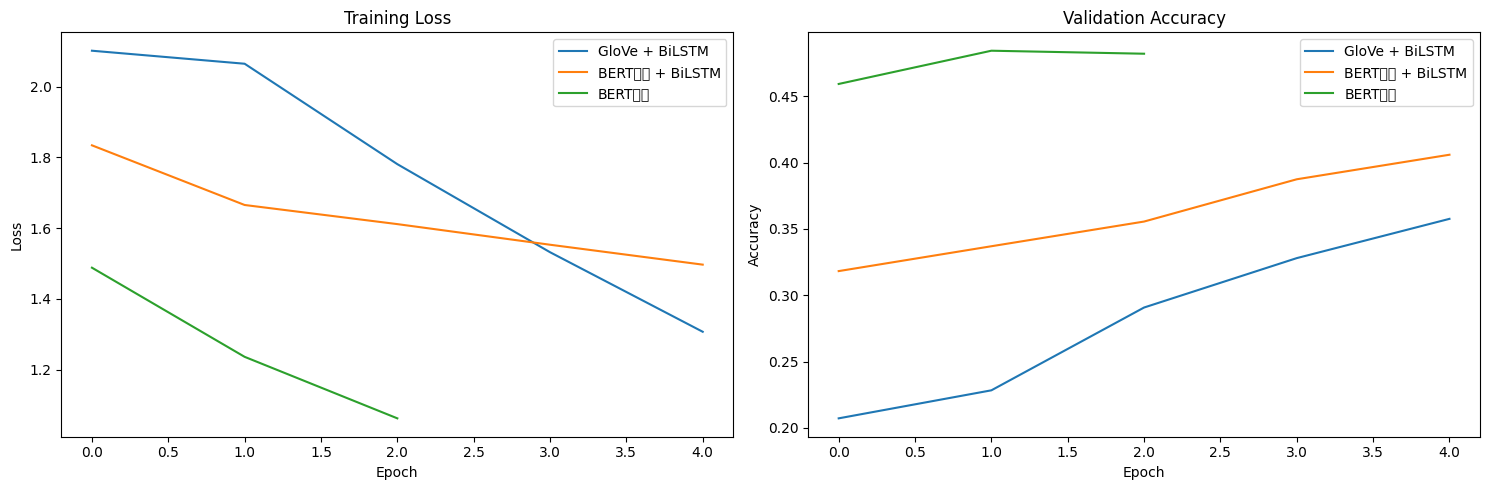


=== Final Results ===
Model 1 (GloVe + BiLSTM) - Best Val Acc: 0.3576
Model 2 (BERT嵌入 + BiLSTM) - Best Val Acc: 0.4059
Model 3 (BERT微调) - Best Val Acc: 0.4843


In [7]:
    
    # 绘制结果
plt.figure(figsize=(15, 5))
    
plt.subplot(1, 2, 1)
plt.plot(train_losses1, label='GloVe + BiLSTM')
plt.plot(train_losses2, label='BERT嵌入 + BiLSTM')
plt.plot(train_losses3, label='BERT微调')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
    
plt.subplot(1, 2, 2)
plt.plot(val_accs1, label='GloVe + BiLSTM')
plt.plot(val_accs2, label='BERT嵌入 + BiLSTM')
plt.plot(val_accs3, label='BERT微调')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
    
plt.tight_layout()
plt.savefig('imdb_results.png')
plt.show()
    
print("\n=== Final Results ===")
print(f"Model 1 (GloVe + BiLSTM) - Best Val Acc: {max(val_accs1):.4f}")
print(f"Model 2 (BERT嵌入 + BiLSTM) - Best Val Acc: {max(val_accs2):.4f}")
print(f"Model 3 (BERT微调) - Best Val Acc: {max(val_accs3):.4f}")

